In [1]:
import numpy as np
import pandas as pd
import torch
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from src.models.model import VSpyct
from src.utils import (calculate_bs, fix_predictions, plot_brier)
from src.data.dataset import SurvivalDataset

In [2]:
data = SurvivalDataset(fname='pbc.rda', path='../data/raw/')
print(data.dataset.head())
X_train, X_test, y_train, y_test = data.get_tensors()

   id  time  status trt        age sex ascites hepato spiders  edema  bili  \
0   1   400       2   1  58.765229   f       1      1       1    1.0  14.5   
1   2  4500       0   1  56.446270   f       0      1       1    0.0   1.1   
2   3  1012       2   1  70.072553   m       0      0       0    0.5   1.4   
3   4  1925       2   1  54.740589   f       0      1       1    0.5   1.8   
4   5  1504       1   2  38.105407   f       0      1       1    0.0   3.4   

  chol  albumin copper  alk.phos     ast trig platelet  protime stage  
0  261     2.60    156    1718.0  137.95  172      190     12.2     4  
1  302     4.14     54    7394.8  113.52   88      221     10.6     3  
2  176     3.48    210     516.0   96.10   55      151     12.0     4  
3  244     2.54     64    6121.8   60.63   92      183     10.3     4  
4  279     3.53    143     671.0  113.15   72      136     10.9     3  
Succesfully created time tensor of shape: torch.Size([418, 4795])
(334, 769) torch.Size([334, 4795]

In [3]:
model = VSpyct(max_depth=3, bs=64)
model.fit(X_train, y_train)

Total variance: 569.7177124023438
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)


Epochs:   1%|          | 1/150 [00:00<00:24,  6.02it/s]

[iteration 0001] loss: 197982817353728.0000


Epochs:   1%|▏         | 2/150 [00:00<00:23,  6.28it/s]

[iteration 0002] loss: 196394759592345.6250


Epochs:   2%|▏         | 3/150 [00:00<00:22,  6.42it/s]

[iteration 0003] loss: 195266142850252.7812


Epochs:   3%|▎         | 4/150 [00:00<00:22,  6.50it/s]

[iteration 0004] loss: 194190253857177.6250


Epochs:   3%|▎         | 5/150 [00:00<00:22,  6.59it/s]

[iteration 0005] loss: 192758534163660.8125


Epochs:   4%|▍         | 6/150 [00:00<00:21,  6.62it/s]

[iteration 0006] loss: 191840963264512.0000


Epochs:   5%|▍         | 7/150 [00:01<00:21,  6.64it/s]

[iteration 0007] loss: 190535074159001.5938


Epochs:   5%|▌         | 8/150 [00:01<00:21,  6.67it/s]

[iteration 0008] loss: 189326642957516.8125


Epochs:   6%|▌         | 9/150 [00:01<00:21,  6.70it/s]

[iteration 0009] loss: 188103048508211.1875


Epochs:   7%|▋         | 10/150 [00:01<00:20,  6.73it/s]

[iteration 0010] loss: 187016561976934.4375


Epochs:   7%|▋         | 11/150 [00:01<00:20,  6.76it/s]

[iteration 0011] loss: 185490701601996.7812


Epochs:   8%|▊         | 12/150 [00:01<00:20,  6.75it/s]

[iteration 0012] loss: 184492547846963.1875


Epochs:   9%|▊         | 13/150 [00:01<00:20,  6.77it/s]

[iteration 0013] loss: 183451464813772.8125


Epochs:   9%|▉         | 14/150 [00:02<00:20,  6.79it/s]

[iteration 0014] loss: 182226523206451.1875


Epochs:  10%|█         | 15/150 [00:02<00:19,  6.77it/s]

[iteration 0015] loss: 180962687975424.0000


Epochs:  11%|█         | 16/150 [00:02<00:19,  6.77it/s]

[iteration 0016] loss: 179904122663731.1875


Epochs:  11%|█▏        | 17/150 [00:02<00:19,  6.77it/s]

[iteration 0017] loss: 178760274726092.8125


Epochs:  12%|█▏        | 18/150 [00:02<00:19,  6.78it/s]

[iteration 0018] loss: 177642138134118.4062


Epochs:  13%|█▎        | 19/150 [00:02<00:19,  6.77it/s]

[iteration 0019] loss: 176398276912742.4062


Epochs:  13%|█▎        | 20/150 [00:02<00:19,  6.79it/s]

[iteration 0020] loss: 175300189985177.6250


Epochs:  14%|█▍        | 21/150 [00:03<00:19,  6.78it/s]

[iteration 0021] loss: 173995332206591.9688


Epochs:  15%|█▍        | 22/150 [00:03<00:18,  6.79it/s]

[iteration 0022] loss: 173192116961280.0312


Epochs:  15%|█▌        | 23/150 [00:03<00:18,  6.79it/s]

[iteration 0023] loss: 171924291584000.0000


Epochs:  16%|█▌        | 24/150 [00:03<00:18,  6.81it/s]

[iteration 0024] loss: 170901338691993.5938


Epochs:  17%|█▋        | 25/150 [00:03<00:18,  6.81it/s]

[iteration 0025] loss: 169709547814912.0000


Epochs:  17%|█▋        | 26/150 [00:03<00:18,  6.80it/s]

[iteration 0026] loss: 168662768287744.0000


Epochs:  18%|█▊        | 27/150 [00:04<00:18,  6.79it/s]

[iteration 0027] loss: 167458717197926.4062


Epochs:  19%|█▊        | 28/150 [00:04<00:17,  6.80it/s]

[iteration 0028] loss: 166470522293452.7812


Epochs:  19%|█▉        | 29/150 [00:04<00:17,  6.81it/s]

[iteration 0029] loss: 165131147018240.0000


Epochs:  20%|██        | 30/150 [00:04<00:17,  6.80it/s]

[iteration 0030] loss: 164293797268684.8125


Epochs:  21%|██        | 31/150 [00:04<00:17,  6.79it/s]

[iteration 0031] loss: 163160809852108.7812


Epochs:  21%|██▏       | 32/150 [00:04<00:17,  6.76it/s]

[iteration 0032] loss: 161961577178726.4062


Epochs:  22%|██▏       | 33/150 [00:04<00:17,  6.77it/s]

[iteration 0033] loss: 160975098006732.7812


Epochs:  23%|██▎       | 34/150 [00:05<00:17,  6.78it/s]

[iteration 0034] loss: 159911673069568.0000


Epochs:  23%|██▎       | 35/150 [00:05<00:16,  6.77it/s]

[iteration 0035] loss: 158909404282880.0000


Epochs:  24%|██▍       | 36/150 [00:05<00:16,  6.77it/s]

[iteration 0036] loss: 157812970382950.3750


Epochs:  25%|██▍       | 37/150 [00:05<00:16,  6.78it/s]

[iteration 0037] loss: 156916111900672.0000


Epochs:  25%|██▌       | 38/150 [00:05<00:16,  6.77it/s]

[iteration 0038] loss: 155696994032025.6250


Epochs:  26%|██▌       | 39/150 [00:05<00:16,  6.77it/s]

[iteration 0039] loss: 154756335953510.3750


Epochs:  27%|██▋       | 40/150 [00:05<00:16,  6.78it/s]

[iteration 0040] loss: 153739203025305.5938


Epochs:  27%|██▋       | 41/150 [00:06<00:16,  6.76it/s]

[iteration 0041] loss: 152892538722713.5938


Epochs:  28%|██▊       | 42/150 [00:06<00:15,  6.77it/s]

[iteration 0042] loss: 151687373049036.8125


Epochs:  29%|██▊       | 43/150 [00:06<00:15,  6.76it/s]

[iteration 0043] loss: 150574514883788.8125


Epochs:  29%|██▉       | 44/150 [00:06<00:15,  6.78it/s]

[iteration 0044] loss: 149918632430796.7812


Epochs:  30%|███       | 45/150 [00:06<00:15,  6.75it/s]

[iteration 0045] loss: 148694325945958.4062


Epochs:  31%|███       | 46/150 [00:06<00:15,  6.76it/s]

[iteration 0046] loss: 147613142011084.8438


Epochs:  31%|███▏      | 47/150 [00:06<00:15,  6.76it/s]

[iteration 0047] loss: 146582564503552.0312


Epochs:  32%|███▏      | 48/150 [00:07<00:15,  6.78it/s]

[iteration 0048] loss: 145498932563148.7812


Epochs:  33%|███▎      | 49/150 [00:07<00:14,  6.78it/s]

[iteration 0049] loss: 144602627781427.1875


Epochs:  33%|███▎      | 50/150 [00:07<00:14,  6.79it/s]

[iteration 0050] loss: 143663435035443.1875


Epochs:  34%|███▍      | 51/150 [00:07<00:14,  6.79it/s]

[iteration 0051] loss: 142812249692569.6250


Epochs:  35%|███▍      | 52/150 [00:07<00:14,  6.81it/s]

[iteration 0052] loss: 141730415326003.1875


Epochs:  35%|███▌      | 53/150 [00:07<00:14,  6.79it/s]

[iteration 0053] loss: 140860997133926.4062


Epochs:  36%|███▌      | 54/150 [00:08<00:14,  6.74it/s]

[iteration 0054] loss: 139694307488563.2188


Epochs:  37%|███▋      | 55/150 [00:08<00:14,  6.75it/s]

[iteration 0055] loss: 138809566717542.3906


Epochs:  37%|███▋      | 56/150 [00:08<00:13,  6.75it/s]

[iteration 0056] loss: 137817459680870.4062


Epochs:  38%|███▊      | 57/150 [00:08<00:13,  6.75it/s]

[iteration 0057] loss: 136784199077068.8125


Epochs:  39%|███▊      | 58/150 [00:08<00:13,  6.75it/s]

[iteration 0058] loss: 135996502704128.0312


Epochs:  39%|███▉      | 59/150 [00:08<00:13,  6.76it/s]

[iteration 0059] loss: 135108394116710.3906


Epochs:  40%|████      | 60/150 [00:08<00:13,  6.76it/s]

[iteration 0060] loss: 134258187776819.2188


Epochs:  41%|████      | 61/150 [00:09<00:13,  6.78it/s]

[iteration 0061] loss: 133100552375500.8125


Epochs:  41%|████▏     | 62/150 [00:09<00:12,  6.77it/s]

[iteration 0062] loss: 132095875324313.5938


Epochs:  42%|████▏     | 63/150 [00:09<00:12,  6.76it/s]

[iteration 0063] loss: 131389404479488.0312


Epochs:  43%|████▎     | 64/150 [00:09<00:12,  6.76it/s]

[iteration 0064] loss: 130278357729280.0000


Epochs:  43%|████▎     | 65/150 [00:09<00:12,  6.78it/s]

[iteration 0065] loss: 129386322067455.9844


Epochs:  44%|████▍     | 66/150 [00:09<00:12,  6.76it/s]

[iteration 0066] loss: 128594326165913.5938


Epochs:  45%|████▍     | 67/150 [00:09<00:12,  6.76it/s]

[iteration 0067] loss: 127859930169344.0000


Epochs:  45%|████▌     | 68/150 [00:10<00:12,  6.73it/s]

[iteration 0068] loss: 126866184313241.5938


Epochs:  46%|████▌     | 69/150 [00:10<00:12,  6.74it/s]

[iteration 0069] loss: 125994720192102.3906


Epochs:  47%|████▋     | 70/150 [00:10<00:11,  6.75it/s]

[iteration 0070] loss: 125122225740185.6250


Epochs:  47%|████▋     | 71/150 [00:10<00:11,  6.74it/s]

[iteration 0071] loss: 124225985131315.2031


Epochs:  48%|████▊     | 72/150 [00:10<00:11,  6.76it/s]

[iteration 0072] loss: 123250762370252.8125


Epochs:  49%|████▊     | 73/150 [00:10<00:11,  6.74it/s]

[iteration 0073] loss: 122508109938688.0000


Epochs:  49%|████▉     | 74/150 [00:10<00:11,  6.74it/s]

[iteration 0074] loss: 121363824640000.0000


Epochs:  50%|█████     | 75/150 [00:11<00:11,  6.75it/s]

[iteration 0075] loss: 120797064540979.1875


Epochs:  51%|█████     | 76/150 [00:11<00:10,  6.77it/s]

[iteration 0076] loss: 119715835779481.5781


Epochs:  51%|█████▏    | 77/150 [00:11<00:10,  6.77it/s]

[iteration 0077] loss: 118799061640806.4062


Epochs:  52%|█████▏    | 78/150 [00:11<00:10,  6.76it/s]

[iteration 0078] loss: 118125268985446.4062


Epochs:  53%|█████▎    | 79/150 [00:11<00:10,  6.76it/s]

[iteration 0079] loss: 117141064594227.1719


Epochs:  53%|█████▎    | 80/150 [00:11<00:10,  6.76it/s]

[iteration 0080] loss: 116302435581952.0000


Epochs:  54%|█████▍    | 81/150 [00:12<00:10,  6.75it/s]

[iteration 0081] loss: 115572519940915.1719


Epochs:  55%|█████▍    | 82/150 [00:12<00:10,  6.73it/s]

[iteration 0082] loss: 114650031325184.0156


Epochs:  55%|█████▌    | 83/150 [00:12<00:09,  6.74it/s]

[iteration 0083] loss: 113806852646502.4062


Epochs:  56%|█████▌    | 84/150 [00:12<00:09,  6.74it/s]

[iteration 0084] loss: 112977566341529.6094


Epochs:  57%|█████▋    | 85/150 [00:12<00:09,  6.52it/s]

[iteration 0085] loss: 112341287803289.5938


Epochs:  57%|█████▋    | 86/150 [00:12<00:09,  6.58it/s]

[iteration 0086] loss: 111445244536422.4062


Epochs:  58%|█████▊    | 87/150 [00:12<00:09,  6.64it/s]

[iteration 0087] loss: 110598573103513.5938


Epochs:  59%|█████▊    | 88/150 [00:13<00:09,  6.66it/s]

[iteration 0088] loss: 109827217214668.8125


Epochs:  59%|█████▉    | 89/150 [00:13<00:09,  6.68it/s]

[iteration 0089] loss: 108914049915289.6094


Epochs:  60%|██████    | 90/150 [00:13<00:08,  6.68it/s]

[iteration 0090] loss: 108021594508492.7969


Epochs:  61%|██████    | 91/150 [00:13<00:08,  6.70it/s]

[iteration 0091] loss: 107328568976998.3906


Epochs:  61%|██████▏   | 92/150 [00:13<00:08,  6.70it/s]

[iteration 0092] loss: 106376126057676.8125


Epochs:  62%|██████▏   | 93/150 [00:13<00:08,  6.70it/s]

[iteration 0093] loss: 105812894888755.1875


Epochs:  63%|██████▎   | 94/150 [00:13<00:08,  6.72it/s]

[iteration 0094] loss: 105132652809420.7969


Epochs:  63%|██████▎   | 95/150 [00:14<00:08,  6.74it/s]

[iteration 0095] loss: 104312567024844.8125


Epochs:  64%|██████▍   | 96/150 [00:14<00:07,  6.75it/s]

[iteration 0096] loss: 103608845598720.0156


Epochs:  65%|██████▍   | 97/150 [00:14<00:07,  6.77it/s]

[iteration 0097] loss: 102852650441113.6094


Epochs:  65%|██████▌   | 98/150 [00:14<00:07,  6.75it/s]

[iteration 0098] loss: 102049935943270.4062


Epochs:  66%|██████▌   | 99/150 [00:14<00:07,  6.76it/s]

[iteration 0099] loss: 101195291610316.8125


Epochs:  67%|██████▋   | 100/150 [00:14<00:07,  6.75it/s]

[iteration 0100] loss: 100352755027148.7969


Epochs:  67%|██████▋   | 101/150 [00:14<00:07,  6.74it/s]

[iteration 0101] loss: 99643003292876.7812


Epochs:  68%|██████▊   | 102/150 [00:15<00:07,  6.70it/s]

[iteration 0102] loss: 98918969796198.3906


Epochs:  69%|██████▊   | 103/150 [00:15<00:07,  6.71it/s]

[iteration 0103] loss: 98085994705715.2031


Epochs:  69%|██████▉   | 104/150 [00:15<00:06,  6.73it/s]

[iteration 0104] loss: 97363425545420.7812


Epochs:  70%|███████   | 105/150 [00:15<00:06,  6.73it/s]

[iteration 0105] loss: 96726509001113.5781


Epochs:  71%|███████   | 106/150 [00:15<00:06,  6.74it/s]

[iteration 0106] loss: 96029433449676.8125


Epochs:  71%|███████▏  | 107/150 [00:15<00:06,  6.72it/s]

[iteration 0107] loss: 95303652815667.2031


Epochs:  72%|███████▏  | 108/150 [00:16<00:06,  6.71it/s]

[iteration 0108] loss: 94476541571891.1875


Epochs:  73%|███████▎  | 109/150 [00:16<00:06,  6.71it/s]

[iteration 0109] loss: 93812534227763.2031


Epochs:  73%|███████▎  | 110/150 [00:16<00:05,  6.72it/s]

[iteration 0110] loss: 93083456031948.8125


Epochs:  74%|███████▍  | 111/150 [00:16<00:05,  6.72it/s]

[iteration 0111] loss: 92268367183872.0000


Epochs:  75%|███████▍  | 112/150 [00:16<00:05,  6.74it/s]

[iteration 0112] loss: 91540729469337.5938


Epochs:  75%|███████▌  | 113/150 [00:16<00:05,  6.61it/s]

[iteration 0113] loss: 90865854264115.1875


Epochs:  76%|███████▌  | 114/150 [00:16<00:05,  6.65it/s]

[iteration 0114] loss: 90121967029452.7969


Epochs:  77%|███████▋  | 115/150 [00:17<00:05,  6.68it/s]

[iteration 0115] loss: 89461512758886.3906


Epochs:  77%|███████▋  | 116/150 [00:17<00:05,  6.69it/s]

[iteration 0116] loss: 88961171062784.0000


Epochs:  78%|███████▊  | 117/150 [00:17<00:04,  6.64it/s]

[iteration 0117] loss: 88104752146022.4062


Epochs:  79%|███████▊  | 118/150 [00:17<00:05,  6.35it/s]

[iteration 0118] loss: 87365524127744.0000


Epochs:  79%|███████▉  | 119/150 [00:17<00:04,  6.38it/s]

[iteration 0119] loss: 86730982005145.6094


Epochs:  80%|████████  | 120/150 [00:17<00:04,  6.49it/s]

[iteration 0120] loss: 86096359587840.0000


Epochs:  81%|████████  | 121/150 [00:18<00:04,  6.50it/s]

[iteration 0121] loss: 85364740849663.9844


Epochs:  81%|████████▏ | 122/150 [00:18<00:04,  6.45it/s]

[iteration 0122] loss: 84752374824960.0000


Epochs:  82%|████████▏ | 123/150 [00:18<00:04,  6.51it/s]

[iteration 0123] loss: 84041466065715.2031


Epochs:  83%|████████▎ | 124/150 [00:18<00:04,  6.38it/s]

[iteration 0124] loss: 83416786980044.7969


Epochs:  83%|████████▎ | 125/150 [00:18<00:03,  6.35it/s]

[iteration 0125] loss: 82735461957632.0000


Epochs:  84%|████████▍ | 126/150 [00:18<00:03,  6.44it/s]

[iteration 0126] loss: 81972244722483.2031


Epochs:  85%|████████▍ | 127/150 [00:18<00:03,  6.51it/s]

[iteration 0127] loss: 81527730051481.5938


Epochs:  85%|████████▌ | 128/150 [00:19<00:03,  6.45it/s]

[iteration 0128] loss: 80906780278784.0000


Epochs:  86%|████████▌ | 129/150 [00:19<00:03,  6.37it/s]

[iteration 0129] loss: 80028972954419.2031


Epochs:  87%|████████▋ | 130/150 [00:19<00:03,  6.19it/s]

[iteration 0130] loss: 79445618065408.0000


Epochs:  87%|████████▋ | 131/150 [00:19<00:03,  6.30it/s]

[iteration 0131] loss: 78828263623884.7969


Epochs:  88%|████████▊ | 132/150 [00:19<00:02,  6.39it/s]

[iteration 0132] loss: 78138006568960.0000


Epochs:  89%|████████▊ | 133/150 [00:19<00:02,  6.48it/s]

[iteration 0133] loss: 77562248796569.5938


Epochs:  89%|████████▉ | 134/150 [00:20<00:02,  6.51it/s]

[iteration 0134] loss: 76976182342451.2031


Epochs:  90%|█████████ | 135/150 [00:20<00:02,  6.45it/s]

[iteration 0135] loss: 76333733616025.6094


Epochs:  91%|█████████ | 136/150 [00:20<00:02,  6.37it/s]

[iteration 0136] loss: 75641613923123.1875


Epochs:  91%|█████████▏| 137/150 [00:20<00:02,  6.33it/s]

[iteration 0137] loss: 75039183627878.3906


Epochs:  92%|█████████▏| 138/150 [00:20<00:01,  6.29it/s]

[iteration 0138] loss: 74403502489600.0000


Epochs:  93%|█████████▎| 139/150 [00:20<00:01,  6.27it/s]

[iteration 0139] loss: 73825559406182.3906


Epochs:  93%|█████████▎| 140/150 [00:20<00:01,  6.26it/s]

[iteration 0140] loss: 73317899881676.7969


Epochs:  94%|█████████▍| 141/150 [00:21<00:01,  6.24it/s]

[iteration 0141] loss: 72647592430796.8125


Epochs:  95%|█████████▍| 142/150 [00:21<00:01,  6.24it/s]

[iteration 0142] loss: 71879812893900.7969


Epochs:  95%|█████████▌| 143/150 [00:21<00:01,  6.34it/s]

[iteration 0143] loss: 71380989273702.3906


Epochs:  96%|█████████▌| 144/150 [00:21<00:00,  6.41it/s]

[iteration 0144] loss: 70883402606182.4062


Epochs:  97%|█████████▋| 145/150 [00:21<00:00,  6.48it/s]

[iteration 0145] loss: 70306660981145.6016


Epochs:  97%|█████████▋| 146/150 [00:21<00:00,  6.47it/s]

[iteration 0146] loss: 69760226898739.2031


Epochs:  98%|█████████▊| 147/150 [00:22<00:00,  6.52it/s]

[iteration 0147] loss: 68980828825190.3984


Epochs:  99%|█████████▊| 148/150 [00:22<00:00,  6.56it/s]

[iteration 0148] loss: 68395012561305.5938


Epochs:  99%|█████████▉| 149/150 [00:22<00:00,  6.50it/s]

[iteration 0149] loss: 67824850121523.1953


Epochs: 100%|██████████| 150/150 [00:22<00:00,  6.65it/s]


[iteration 0150] loss: 67299450316390.4062
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)
torch.Size([334, 769])
Var left tensor(528.9999)
Var right tensor(571.4787)
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)


Epochs:   1%|          | 1/150 [00:00<00:22,  6.65it/s]

[iteration 0001] loss: 196826161322393.5938


Epochs:   1%|▏         | 2/150 [00:00<00:21,  6.80it/s]

[iteration 0002] loss: 195299870192435.1875


Epochs:   2%|▏         | 3/150 [00:00<00:21,  6.70it/s]

[iteration 0003] loss: 194294064244326.4062


Epochs:   3%|▎         | 4/150 [00:00<00:22,  6.49it/s]

[iteration 0004] loss: 192969855257804.8125


Epochs:   3%|▎         | 5/150 [00:00<00:22,  6.50it/s]

[iteration 0005] loss: 191776790360883.1875


Epochs:   4%|▍         | 6/150 [00:00<00:22,  6.54it/s]

[iteration 0006] loss: 190514555885977.5938


Epochs:   5%|▍         | 7/150 [00:01<00:24,  5.96it/s]

[iteration 0007] loss: 189432674281062.4062


Epochs:   5%|▌         | 8/150 [00:01<00:23,  6.11it/s]

[iteration 0008] loss: 188326844196454.4062


Epochs:   6%|▌         | 9/150 [00:01<00:22,  6.19it/s]

[iteration 0009] loss: 187308707099443.2188


Epochs:   7%|▋         | 10/150 [00:01<00:22,  6.31it/s]

[iteration 0010] loss: 186102154264576.0000


Epochs:   7%|▋         | 11/150 [00:01<00:21,  6.38it/s]

[iteration 0011] loss: 184805168932454.3750


Epochs:   8%|▊         | 12/150 [00:01<00:21,  6.45it/s]

[iteration 0012] loss: 183525337412403.2188


Epochs:   9%|▊         | 13/150 [00:02<00:21,  6.40it/s]

[iteration 0013] loss: 182431409713971.2188


Epochs:   9%|▉         | 14/150 [00:02<00:21,  6.38it/s]

[iteration 0014] loss: 181578997642035.1875


Epochs:  10%|█         | 15/150 [00:02<00:20,  6.44it/s]

[iteration 0015] loss: 180274107777024.0312


Epochs:  11%|█         | 16/150 [00:02<00:20,  6.51it/s]

[iteration 0016] loss: 178972535134617.6250


Epochs:  11%|█▏        | 17/150 [00:02<00:20,  6.57it/s]

[iteration 0017] loss: 177817986216755.2188


Epochs:  12%|█▏        | 18/150 [00:02<00:20,  6.59it/s]

[iteration 0018] loss: 176708801318092.8125


Epochs:  13%|█▎        | 19/150 [00:02<00:19,  6.59it/s]

[iteration 0019] loss: 175784159451545.5938


Epochs:  13%|█▎        | 20/150 [00:03<00:20,  6.48it/s]

[iteration 0020] loss: 174555204209868.7812


Epochs:  14%|█▍        | 21/150 [00:03<00:20,  6.45it/s]

[iteration 0021] loss: 173345682699059.2188


Epochs:  15%|█▍        | 22/150 [00:03<00:20,  6.35it/s]

[iteration 0022] loss: 172294204764979.2188


Epochs:  15%|█▌        | 23/150 [00:03<00:20,  6.28it/s]

[iteration 0023] loss: 171380424205926.3750


Epochs:  16%|█▌        | 24/150 [00:03<00:20,  6.25it/s]

[iteration 0024] loss: 170016382753177.5625


Epochs:  17%|█▋        | 25/150 [00:03<00:19,  6.33it/s]

[iteration 0025] loss: 169012074905600.0000


Epochs:  17%|█▋        | 26/150 [00:04<00:19,  6.40it/s]

[iteration 0026] loss: 167796348446310.4062


Epochs:  18%|█▊        | 27/150 [00:04<00:19,  6.45it/s]

[iteration 0027] loss: 166865605964595.1875


Epochs:  19%|█▊        | 28/150 [00:04<00:19,  6.29it/s]

[iteration 0028] loss: 165772911496396.8125


Epochs:  19%|█▉        | 29/150 [00:04<00:18,  6.38it/s]

[iteration 0029] loss: 164717480745369.5938


Epochs:  20%|██        | 30/150 [00:04<00:18,  6.45it/s]

[iteration 0030] loss: 163580471620403.1875


Epochs:  21%|██        | 31/150 [00:04<00:18,  6.50it/s]

[iteration 0031] loss: 162560567830118.4062


Epochs:  21%|██▏       | 32/150 [00:04<00:18,  6.44it/s]

[iteration 0032] loss: 161600060679782.4062


Epochs:  22%|██▏       | 33/150 [00:05<00:18,  6.40it/s]

[iteration 0033] loss: 160344660928102.3750


Epochs:  23%|██▎       | 34/150 [00:05<00:18,  6.37it/s]

[iteration 0034] loss: 159437306619494.3750


Epochs:  23%|██▎       | 35/150 [00:05<00:18,  6.32it/s]

[iteration 0035] loss: 158381969506304.0000


Epochs:  24%|██▍       | 36/150 [00:05<00:18,  6.27it/s]

[iteration 0036] loss: 157437388495257.5938


Epochs:  25%|██▍       | 37/150 [00:05<00:18,  6.24it/s]

[iteration 0037] loss: 156199660394905.5938


Epochs:  25%|██▌       | 38/150 [00:05<00:17,  6.23it/s]

[iteration 0038] loss: 155219318276096.0000


Epochs:  26%|██▌       | 39/150 [00:06<00:17,  6.22it/s]

[iteration 0039] loss: 153999759428812.8125


Epochs:  27%|██▋       | 40/150 [00:06<00:17,  6.16it/s]

[iteration 0040] loss: 153074819661824.0000


Epochs:  27%|██▋       | 41/150 [00:06<00:17,  6.16it/s]

[iteration 0041] loss: 152261615891251.1875


Epochs:  28%|██▊       | 42/150 [00:06<00:17,  6.16it/s]

[iteration 0042] loss: 151219186381619.1875


Epochs:  29%|██▊       | 43/150 [00:06<00:17,  6.17it/s]

[iteration 0043] loss: 150264315746713.5938


Epochs:  29%|██▉       | 44/150 [00:06<00:17,  5.91it/s]

[iteration 0044] loss: 149236338130944.0312


Epochs:  30%|███       | 45/150 [00:07<00:17,  6.06it/s]

[iteration 0045] loss: 148150000340172.7812


Epochs:  31%|███       | 46/150 [00:07<00:18,  5.70it/s]

[iteration 0046] loss: 147214949941248.0000


Epochs:  31%|███▏      | 47/150 [00:07<00:17,  5.76it/s]

[iteration 0047] loss: 146128961326284.7812


Epochs:  32%|███▏      | 48/150 [00:07<00:17,  5.74it/s]

[iteration 0048] loss: 145318083035136.0000


Epochs:  33%|███▎      | 49/150 [00:07<00:17,  5.92it/s]

[iteration 0049] loss: 144192087418470.4062


Epochs:  33%|███▎      | 50/150 [00:07<00:16,  5.94it/s]

[iteration 0050] loss: 143189458236211.2188


Epochs:  34%|███▍      | 51/150 [00:08<00:16,  5.93it/s]

[iteration 0051] loss: 142257731456204.7812


Epochs:  35%|███▍      | 52/150 [00:08<00:16,  6.03it/s]

[iteration 0052] loss: 141249239528243.1875


Epochs:  35%|███▌      | 53/150 [00:08<00:15,  6.15it/s]

[iteration 0053] loss: 140503264788480.0000


Epochs:  36%|███▌      | 54/150 [00:08<00:15,  6.23it/s]

[iteration 0054] loss: 139558870476390.4219


Epochs:  37%|███▋      | 55/150 [00:08<00:15,  6.27it/s]

[iteration 0055] loss: 138519698735103.9844


Epochs:  37%|███▋      | 56/150 [00:08<00:14,  6.33it/s]

[iteration 0056] loss: 137522830324531.2031


Epochs:  38%|███▊      | 57/150 [00:09<00:14,  6.42it/s]

[iteration 0057] loss: 136569468485631.9844


Epochs:  39%|███▊      | 58/150 [00:09<00:14,  6.46it/s]

[iteration 0058] loss: 135690040901632.0000


Epochs:  39%|███▉      | 59/150 [00:09<00:14,  6.49it/s]

[iteration 0059] loss: 134710003446579.1875


Epochs:  40%|████      | 60/150 [00:09<00:14,  6.39it/s]

[iteration 0060] loss: 133761735956889.6094


Epochs:  41%|████      | 61/150 [00:09<00:14,  6.30it/s]

[iteration 0061] loss: 132908325221171.1875


Epochs:  41%|████▏     | 62/150 [00:09<00:13,  6.37it/s]

[iteration 0062] loss: 131978728675737.6094


Epochs:  42%|████▏     | 63/150 [00:10<00:13,  6.44it/s]

[iteration 0063] loss: 131084075820646.3906


Epochs:  43%|████▎     | 64/150 [00:10<00:13,  6.49it/s]

[iteration 0064] loss: 130178112343244.7969


Epochs:  43%|████▎     | 65/150 [00:10<00:13,  6.51it/s]

[iteration 0065] loss: 129276534220390.3906


Epochs:  44%|████▍     | 66/150 [00:10<00:12,  6.52it/s]

[iteration 0066] loss: 128403119276032.0000


Epochs:  45%|████▍     | 67/150 [00:10<00:13,  6.32it/s]

[iteration 0067] loss: 127443548923494.4062


Epochs:  45%|████▌     | 68/150 [00:10<00:12,  6.37it/s]

[iteration 0068] loss: 126827612916940.7969


Epochs:  46%|████▌     | 69/150 [00:10<00:12,  6.42it/s]

[iteration 0069] loss: 125742999352115.2031


Epochs:  47%|████▋     | 70/150 [00:11<00:12,  6.43it/s]

[iteration 0070] loss: 124778699135385.5938


Epochs:  47%|████▋     | 71/150 [00:11<00:12,  6.48it/s]

[iteration 0071] loss: 123892123670937.6094


Epochs:  48%|████▊     | 72/150 [00:11<00:11,  6.50it/s]

[iteration 0072] loss: 123209798385664.0000


Epochs:  49%|████▊     | 73/150 [00:11<00:11,  6.52it/s]

[iteration 0073] loss: 122340129741209.6094


Epochs:  49%|████▉     | 74/150 [00:11<00:11,  6.54it/s]

[iteration 0074] loss: 121401648978329.5938


Epochs:  50%|█████     | 75/150 [00:11<00:11,  6.54it/s]

[iteration 0075] loss: 120560392549171.2031


Epochs:  51%|█████     | 76/150 [00:12<00:11,  6.54it/s]

[iteration 0076] loss: 119495286639820.7812


Epochs:  51%|█████▏    | 77/150 [00:12<00:11,  6.54it/s]

[iteration 0077] loss: 118759550143692.7969


Epochs:  52%|█████▏    | 78/150 [00:12<00:11,  6.53it/s]

[iteration 0078] loss: 117895211148902.3906


Epochs:  53%|█████▎    | 79/150 [00:12<00:10,  6.53it/s]

[iteration 0079] loss: 116981447576780.8125


Epochs:  53%|█████▎    | 80/150 [00:12<00:10,  6.53it/s]

[iteration 0080] loss: 116243668192460.8125


Epochs:  54%|█████▍    | 81/150 [00:12<00:10,  6.57it/s]

[iteration 0081] loss: 115497588018380.7812


Epochs:  55%|█████▍    | 82/150 [00:12<00:10,  6.56it/s]

[iteration 0082] loss: 114762077070950.4062


Epochs:  55%|█████▌    | 83/150 [00:13<00:10,  6.57it/s]

[iteration 0083] loss: 113806445222297.5938


Epochs:  56%|█████▌    | 84/150 [00:13<00:10,  6.57it/s]

[iteration 0084] loss: 112920697870745.6094


Epochs:  57%|█████▋    | 85/150 [00:13<00:09,  6.56it/s]

[iteration 0085] loss: 112360276046643.2031


Epochs:  57%|█████▋    | 86/150 [00:13<00:09,  6.55it/s]

[iteration 0086] loss: 111263828174438.3906


Epochs:  58%|█████▊    | 87/150 [00:13<00:09,  6.54it/s]

[iteration 0087] loss: 110504390452838.4062


Epochs:  59%|█████▊    | 88/150 [00:13<00:09,  6.54it/s]

[iteration 0088] loss: 109602968908595.1875


Epochs:  59%|█████▉    | 89/150 [00:14<00:09,  6.55it/s]

[iteration 0089] loss: 108970970998374.3906


Epochs:  60%|██████    | 90/150 [00:14<00:09,  6.53it/s]

[iteration 0090] loss: 108142857289728.0156


Epochs:  61%|██████    | 91/150 [00:14<00:09,  6.52it/s]

[iteration 0091] loss: 107260411091353.5938


Epochs:  61%|██████▏   | 92/150 [00:14<00:08,  6.53it/s]

[iteration 0092] loss: 106560009928704.0000


Epochs:  62%|██████▏   | 93/150 [00:14<00:08,  6.56it/s]

[iteration 0093] loss: 105767743232409.5938


Epochs:  63%|██████▎   | 94/150 [00:14<00:08,  6.56it/s]

[iteration 0094] loss: 104918339000729.6094


Epochs:  63%|██████▎   | 95/150 [00:14<00:08,  6.55it/s]

[iteration 0095] loss: 104242006170009.6094


Epochs:  64%|██████▍   | 96/150 [00:15<00:08,  6.54it/s]

[iteration 0096] loss: 103505548646809.6094


Epochs:  65%|██████▍   | 97/150 [00:15<00:08,  6.53it/s]

[iteration 0097] loss: 102722576030105.5938


Epochs:  65%|██████▌   | 98/150 [00:15<00:07,  6.54it/s]

[iteration 0098] loss: 101904185268633.5938


Epochs:  66%|██████▌   | 99/150 [00:15<00:07,  6.55it/s]

[iteration 0099] loss: 101182379183308.7969


Epochs:  67%|██████▋   | 100/150 [00:15<00:07,  6.55it/s]

[iteration 0100] loss: 100496170627891.1875


Epochs:  67%|██████▋   | 101/150 [00:15<00:07,  6.62it/s]

[iteration 0101] loss: 99661748712243.2031


Epochs:  68%|██████▊   | 102/150 [00:15<00:07,  6.63it/s]

[iteration 0102] loss: 99108426796236.7969


Epochs:  69%|██████▊   | 103/150 [00:16<00:06,  6.73it/s]

[iteration 0103] loss: 98264992265011.2031


Epochs:  69%|██████▉   | 104/150 [00:16<00:06,  6.69it/s]

[iteration 0104] loss: 97576905893478.4062


Epochs:  70%|███████   | 105/150 [00:16<00:06,  6.72it/s]

[iteration 0105] loss: 96754872300339.2031


Epochs:  71%|███████   | 106/150 [00:16<00:06,  6.75it/s]

[iteration 0106] loss: 95988156438937.5938


Epochs:  71%|███████▏  | 107/150 [00:16<00:06,  6.71it/s]

[iteration 0107] loss: 95292916262502.3906


Epochs:  72%|███████▏  | 108/150 [00:16<00:06,  6.80it/s]

[iteration 0108] loss: 94447592354611.1875


Epochs:  73%|███████▎  | 109/150 [00:17<00:06,  6.77it/s]

[iteration 0109] loss: 93912188426649.5938


Epochs:  73%|███████▎  | 110/150 [00:17<00:05,  6.73it/s]

[iteration 0110] loss: 93184141479116.7969


Epochs:  74%|███████▍  | 111/150 [00:17<00:05,  6.81it/s]

[iteration 0111] loss: 92383895722393.6094


Epochs:  75%|███████▍  | 112/150 [00:17<00:05,  6.75it/s]

[iteration 0112] loss: 91673452399820.8125


Epochs:  75%|███████▌  | 113/150 [00:17<00:05,  6.75it/s]

[iteration 0113] loss: 91077746281676.7969


Epochs:  76%|███████▌  | 114/150 [00:17<00:05,  6.81it/s]

[iteration 0114] loss: 90391557046272.0000


Epochs:  77%|███████▋  | 115/150 [00:17<00:05,  6.75it/s]

[iteration 0115] loss: 89688783401779.2031


Epochs:  77%|███████▋  | 116/150 [00:18<00:04,  6.84it/s]

[iteration 0116] loss: 88983533282918.3906


Epochs:  78%|███████▊  | 117/150 [00:18<00:04,  6.81it/s]

[iteration 0117] loss: 88280704509542.4062


Epochs:  79%|███████▊  | 118/150 [00:18<00:04,  6.75it/s]

[iteration 0118] loss: 87659110413107.2031


Epochs:  79%|███████▉  | 119/150 [00:18<00:04,  6.83it/s]

[iteration 0119] loss: 86758509667942.4062


Epochs:  80%|████████  | 120/150 [00:18<00:04,  6.77it/s]

[iteration 0120] loss: 86242373061836.7969


Epochs:  81%|████████  | 121/150 [00:18<00:04,  6.68it/s]

[iteration 0121] loss: 85628553632153.5938


Epochs:  81%|████████▏ | 122/150 [00:18<00:04,  6.75it/s]

[iteration 0122] loss: 84902438214041.6094


Epochs:  82%|████████▏ | 123/150 [00:19<00:04,  6.48it/s]

[iteration 0123] loss: 84253386394828.8125


Epochs:  83%|████████▎ | 124/150 [00:19<00:03,  6.58it/s]

[iteration 0124] loss: 83650018410496.0156


Epochs:  83%|████████▎ | 125/150 [00:19<00:03,  6.66it/s]

[iteration 0125] loss: 82843408479027.1875


Epochs:  84%|████████▍ | 126/150 [00:19<00:03,  6.64it/s]

[iteration 0126] loss: 82187241547366.3906


Epochs:  85%|████████▍ | 127/150 [00:19<00:03,  6.74it/s]

[iteration 0127] loss: 81528483374694.3906


Epochs:  85%|████████▌ | 128/150 [00:19<00:03,  6.75it/s]

[iteration 0128] loss: 80922049537638.4062


Epochs:  86%|████████▌ | 129/150 [00:19<00:03,  6.71it/s]

[iteration 0129] loss: 80295391238553.6094


Epochs:  87%|████████▋ | 130/150 [00:20<00:02,  6.82it/s]

[iteration 0130] loss: 79679302008832.0000


Epochs:  87%|████████▋ | 131/150 [00:20<00:02,  6.75it/s]

[iteration 0131] loss: 78969070813184.0000


Epochs:  88%|████████▊ | 132/150 [00:20<00:02,  6.73it/s]

[iteration 0132] loss: 78344553339289.6094


Epochs:  89%|████████▊ | 133/150 [00:20<00:02,  6.80it/s]

[iteration 0133] loss: 77736606066278.3906


Epochs:  89%|████████▉ | 134/150 [00:20<00:02,  6.76it/s]

[iteration 0134] loss: 77122821659033.6094


Epochs:  90%|█████████ | 135/150 [00:20<00:02,  6.81it/s]

[iteration 0135] loss: 76504216816844.7969


Epochs:  91%|█████████ | 136/150 [00:21<00:02,  6.74it/s]

[iteration 0136] loss: 75865137977753.6250


Epochs:  91%|█████████▏| 137/150 [00:21<00:01,  6.69it/s]

[iteration 0137] loss: 75333442155315.2031


Epochs:  92%|█████████▏| 138/150 [00:21<00:01,  6.79it/s]

[iteration 0138] loss: 74583371677696.0000


Epochs:  93%|█████████▎| 139/150 [00:21<00:01,  6.76it/s]

[iteration 0139] loss: 73955417731891.1875


Epochs:  93%|█████████▎| 140/150 [00:21<00:01,  6.71it/s]

[iteration 0140] loss: 73407616594739.2031


Epochs:  94%|█████████▍| 141/150 [00:21<00:01,  6.81it/s]

[iteration 0141] loss: 72803714177433.5938


Epochs:  95%|█████████▍| 142/150 [00:21<00:01,  6.75it/s]

[iteration 0142] loss: 72318121174630.4062


Epochs:  95%|█████████▌| 143/150 [00:22<00:01,  6.70it/s]

[iteration 0143] loss: 71655101510451.2031


Epochs:  96%|█████████▌| 144/150 [00:22<00:00,  6.61it/s]

[iteration 0144] loss: 70881781717401.5938


Epochs:  97%|█████████▋| 145/150 [00:22<00:00,  6.60it/s]

[iteration 0145] loss: 70590694817792.0000


Epochs:  97%|█████████▋| 146/150 [00:22<00:00,  6.65it/s]

[iteration 0146] loss: 69857821274931.1953


Epochs:  98%|█████████▊| 147/150 [00:22<00:00,  6.71it/s]

[iteration 0147] loss: 69459145261056.0078


Epochs:  99%|█████████▊| 148/150 [00:22<00:00,  6.67it/s]

[iteration 0148] loss: 68836614864896.0000


Epochs:  99%|█████████▉| 149/150 [00:22<00:00,  6.76it/s]

[iteration 0149] loss: 68329267344179.1953


Epochs: 100%|██████████| 150/150 [00:23<00:00,  6.49it/s]


[iteration 0150] loss: 67658473354035.2031
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)
torch.Size([331, 769])
Var left tensor(0.)
Var right tensor(571.4787)
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)


Epochs:   1%|          | 1/150 [00:00<00:22,  6.48it/s]

[iteration 0001] loss: 194528521538764.8125


Epochs:   1%|▏         | 2/150 [00:00<00:21,  6.78it/s]

[iteration 0002] loss: 193304371763609.6250


Epochs:   2%|▏         | 3/150 [00:00<00:21,  6.75it/s]

[iteration 0003] loss: 192126107045068.8125


Epochs:   3%|▎         | 4/150 [00:00<00:21,  6.69it/s]

[iteration 0004] loss: 190734637570457.6250


Epochs:   3%|▎         | 5/150 [00:00<00:21,  6.80it/s]

[iteration 0005] loss: 189606681693388.8125


Epochs:   4%|▍         | 6/150 [00:00<00:21,  6.72it/s]

[iteration 0006] loss: 188433920478412.7812


Epochs:   5%|▍         | 7/150 [00:01<00:21,  6.69it/s]

[iteration 0007] loss: 187399417574195.1875


Epochs:   5%|▌         | 8/150 [00:01<00:20,  6.77it/s]

[iteration 0008] loss: 186335328731136.0000


Epochs:   6%|▌         | 9/150 [00:01<00:21,  6.71it/s]

[iteration 0009] loss: 184777870357299.1875


Epochs:   7%|▋         | 10/150 [00:01<00:20,  6.75it/s]

[iteration 0010] loss: 184060514612019.2188


Epochs:   7%|▋         | 11/150 [00:01<00:20,  6.77it/s]

[iteration 0011] loss: 182537799126220.7812


Epochs:   8%|▊         | 12/150 [00:01<00:20,  6.71it/s]

[iteration 0012] loss: 181385755570995.2188


Epochs:   9%|▊         | 13/150 [00:01<00:20,  6.82it/s]

[iteration 0013] loss: 180368658713804.7812


Epochs:   9%|▉         | 14/150 [00:02<00:20,  6.68it/s]

[iteration 0014] loss: 179115638810214.3750


Epochs:  10%|█         | 15/150 [00:02<00:20,  6.67it/s]

[iteration 0015] loss: 178180462477312.0000


Epochs:  11%|█         | 16/150 [00:02<00:19,  6.77it/s]

[iteration 0016] loss: 176801764658380.8125


Epochs:  11%|█▏        | 17/150 [00:02<00:20,  6.48it/s]

[iteration 0017] loss: 175784678444236.7812


Epochs:  12%|█▏        | 18/150 [00:02<00:20,  6.60it/s]

[iteration 0018] loss: 174699668622540.8125


Epochs:  13%|█▎        | 19/150 [00:02<00:19,  6.65it/s]

[iteration 0019] loss: 173483520321126.4062


Epochs:  13%|█▎        | 20/150 [00:02<00:19,  6.61it/s]

[iteration 0020] loss: 172471633523507.1875


Epochs:  14%|█▍        | 21/150 [00:03<00:19,  6.73it/s]

[iteration 0021] loss: 171264874276454.3750


Epochs:  15%|█▍        | 22/150 [00:03<00:19,  6.69it/s]

[iteration 0022] loss: 170337986936832.0000


Epochs:  15%|█▌        | 23/150 [00:03<00:18,  6.69it/s]

[iteration 0023] loss: 169169544019968.0312


Epochs:  16%|█▌        | 24/150 [00:03<00:18,  6.74it/s]

[iteration 0024] loss: 168022825500672.0000


Epochs:  17%|█▋        | 25/150 [00:03<00:18,  6.71it/s]

[iteration 0025] loss: 167060397096960.0312


Epochs:  17%|█▋        | 26/150 [00:03<00:18,  6.80it/s]

[iteration 0026] loss: 165794964832256.0000


Epochs:  18%|█▊        | 27/150 [00:04<00:18,  6.75it/s]

[iteration 0027] loss: 164859819537203.1875


Epochs:  19%|█▊        | 28/150 [00:04<00:18,  6.66it/s]

[iteration 0028] loss: 163569536912588.8125


Epochs:  19%|█▉        | 29/150 [00:04<00:17,  6.72it/s]

[iteration 0029] loss: 162699577288294.4062


Epochs:  20%|██        | 30/150 [00:04<00:17,  6.67it/s]

[iteration 0030] loss: 161664009974579.1875


Epochs:  21%|██        | 31/150 [00:04<00:17,  6.77it/s]

[iteration 0031] loss: 160378084550246.4062


Epochs:  21%|██▏       | 32/150 [00:04<00:17,  6.70it/s]

[iteration 0032] loss: 159509175284531.1875


Epochs:  22%|██▏       | 33/150 [00:04<00:17,  6.70it/s]

[iteration 0033] loss: 158388405560934.3750


Epochs:  23%|██▎       | 34/150 [00:05<00:17,  6.76it/s]

[iteration 0034] loss: 157437065061990.4062


Epochs:  23%|██▎       | 35/150 [00:05<00:17,  6.70it/s]

[iteration 0035] loss: 156447379711590.3750


Epochs:  24%|██▍       | 36/150 [00:05<00:16,  6.80it/s]

[iteration 0036] loss: 155210697565798.4375


Epochs:  25%|██▍       | 37/150 [00:05<00:16,  6.71it/s]

[iteration 0037] loss: 154418593398784.0000


Epochs:  25%|██▌       | 38/150 [00:05<00:16,  6.74it/s]

[iteration 0038] loss: 153332140421939.1875


Epochs:  26%|██▌       | 39/150 [00:05<00:17,  6.35it/s]

[iteration 0039] loss: 152200136779366.4062


Epochs:  27%|██▋       | 40/150 [00:05<00:17,  6.36it/s]

[iteration 0040] loss: 151224446667980.8125


Epochs:  27%|██▋       | 41/150 [00:06<00:16,  6.51it/s]

[iteration 0041] loss: 150102188910182.3750


Epochs:  28%|██▊       | 42/150 [00:06<00:16,  6.51it/s]

[iteration 0042] loss: 149195239876198.4062


Epochs:  29%|██▊       | 43/150 [00:06<00:16,  6.54it/s]

[iteration 0043] loss: 148204043999641.5938


Epochs:  29%|██▉       | 44/150 [00:06<00:15,  6.67it/s]

[iteration 0044] loss: 147168106800742.3750


Epochs:  30%|███       | 45/150 [00:06<00:15,  6.63it/s]

[iteration 0045] loss: 146162334197350.4062


Epochs:  31%|███       | 46/150 [00:06<00:15,  6.70it/s]

[iteration 0046] loss: 145352233110732.8125


Epochs:  31%|███▏      | 47/150 [00:07<00:15,  6.71it/s]

[iteration 0047] loss: 144140858503987.2188


Epochs:  32%|███▏      | 48/150 [00:07<00:15,  6.67it/s]

[iteration 0048] loss: 143280323795353.6250


Epochs:  33%|███▎      | 49/150 [00:07<00:14,  6.76it/s]

[iteration 0049] loss: 142231897322291.1875


Epochs:  33%|███▎      | 50/150 [00:07<00:14,  6.69it/s]

[iteration 0050] loss: 141388352323584.0000


Epochs:  34%|███▍      | 51/150 [00:07<00:14,  6.73it/s]

[iteration 0051] loss: 140521755639808.0156


Epochs:  35%|███▍      | 52/150 [00:07<00:14,  6.74it/s]

[iteration 0052] loss: 139472498694553.5938


Epochs:  35%|███▌      | 53/150 [00:07<00:14,  6.70it/s]

[iteration 0053] loss: 138415006810111.9844


Epochs:  36%|███▌      | 54/150 [00:08<00:14,  6.79it/s]

[iteration 0054] loss: 137643413733376.0000


Epochs:  37%|███▋      | 55/150 [00:08<00:14,  6.63it/s]

[iteration 0055] loss: 136866413936640.0000


Epochs:  37%|███▋      | 56/150 [00:08<00:13,  6.72it/s]

[iteration 0056] loss: 135729800386969.5781


Epochs:  38%|███▊      | 57/150 [00:08<00:13,  6.71it/s]

[iteration 0057] loss: 134714149568512.0156


Epochs:  39%|███▊      | 58/150 [00:08<00:13,  6.67it/s]

[iteration 0058] loss: 133665233567744.0156


Epochs:  39%|███▉      | 59/150 [00:08<00:13,  6.76it/s]

[iteration 0059] loss: 132871758073036.8125


Epochs:  40%|████      | 60/150 [00:08<00:13,  6.69it/s]

[iteration 0060] loss: 131886427825766.4062


Epochs:  41%|████      | 61/150 [00:09<00:13,  6.49it/s]

[iteration 0061] loss: 130978564381081.5938


Epochs:  41%|████▏     | 62/150 [00:09<00:13,  6.56it/s]

[iteration 0062] loss: 130177627796275.2031


Epochs:  42%|████▏     | 63/150 [00:09<00:13,  6.53it/s]

[iteration 0063] loss: 129280971584307.1875


Epochs:  43%|████▎     | 64/150 [00:09<00:12,  6.67it/s]

[iteration 0064] loss: 128405523293798.4219


Epochs:  43%|████▎     | 65/150 [00:09<00:12,  6.60it/s]

[iteration 0065] loss: 127579321112985.6250


Epochs:  44%|████▍     | 66/150 [00:09<00:12,  6.66it/s]

[iteration 0066] loss: 126637188998758.3906


Epochs:  45%|████▍     | 67/150 [00:10<00:12,  6.69it/s]

[iteration 0067] loss: 125618792851046.4062


Epochs:  45%|████▌     | 68/150 [00:10<00:12,  6.59it/s]

[iteration 0068] loss: 124695409747558.4062


Epochs:  46%|████▌     | 69/150 [00:10<00:12,  6.71it/s]

[iteration 0069] loss: 123814793130803.1875


Epochs:  47%|████▋     | 70/150 [00:10<00:12,  6.65it/s]

[iteration 0070] loss: 122925467670937.6094


Epochs:  47%|████▋     | 71/150 [00:10<00:11,  6.71it/s]

[iteration 0071] loss: 122250713681100.7969


Epochs:  48%|████▊     | 72/150 [00:10<00:11,  6.72it/s]

[iteration 0072] loss: 121189231807692.7969


Epochs:  49%|████▊     | 73/150 [00:10<00:11,  6.68it/s]

[iteration 0073] loss: 120454917023334.4062


Epochs:  49%|████▉     | 74/150 [00:11<00:11,  6.78it/s]

[iteration 0074] loss: 119630485363097.5938


Epochs:  50%|█████     | 75/150 [00:11<00:11,  6.70it/s]

[iteration 0075] loss: 118841885432217.6094


Epochs:  51%|█████     | 76/150 [00:11<00:10,  6.76it/s]

[iteration 0076] loss: 117881149168025.6250


Epochs:  51%|█████▏    | 77/150 [00:11<00:10,  6.74it/s]

[iteration 0077] loss: 117167143885209.6094


Epochs:  52%|█████▏    | 78/150 [00:11<00:10,  6.67it/s]

[iteration 0078] loss: 116104239408742.3906


Epochs:  53%|█████▎    | 79/150 [00:11<00:10,  6.77it/s]

[iteration 0079] loss: 115426845733683.2188


Epochs:  53%|█████▎    | 80/150 [00:11<00:10,  6.63it/s]

[iteration 0080] loss: 114515923959808.0000


Epochs:  54%|█████▍    | 81/150 [00:12<00:10,  6.73it/s]

[iteration 0081] loss: 113700876163481.5938


Epochs:  55%|█████▍    | 82/150 [00:12<00:10,  6.71it/s]

[iteration 0082] loss: 112916125109452.8125


Epochs:  55%|█████▌    | 83/150 [00:12<00:10,  6.67it/s]

[iteration 0083] loss: 111874607939584.0000


Epochs:  56%|█████▌    | 84/150 [00:12<00:09,  6.75it/s]

[iteration 0084] loss: 111367325194649.5938


Epochs:  57%|█████▋    | 85/150 [00:12<00:09,  6.69it/s]

[iteration 0085] loss: 110631830552576.0156


Epochs:  57%|█████▋    | 86/150 [00:12<00:09,  6.74it/s]

[iteration 0086] loss: 109686010072268.7969


Epochs:  58%|█████▊    | 87/150 [00:13<00:09,  6.70it/s]

[iteration 0087] loss: 108877158914457.5938


Epochs:  59%|█████▊    | 88/150 [00:13<00:09,  6.65it/s]

[iteration 0088] loss: 107972310361702.4062


Epochs:  59%|█████▉    | 89/150 [00:13<00:09,  6.72it/s]

[iteration 0089] loss: 107402719448268.8125


Epochs:  60%|██████    | 90/150 [00:13<00:08,  6.67it/s]

[iteration 0090] loss: 106434652851404.7969


Epochs:  61%|██████    | 91/150 [00:13<00:08,  6.74it/s]

[iteration 0091] loss: 105845657252659.1875


Epochs:  61%|██████▏   | 92/150 [00:13<00:08,  6.71it/s]

[iteration 0092] loss: 104992266754457.5938


Epochs:  62%|██████▏   | 93/150 [00:13<00:08,  6.62it/s]

[iteration 0093] loss: 104089046378086.4062


Epochs:  63%|██████▎   | 94/150 [00:14<00:08,  6.71it/s]

[iteration 0094] loss: 103293287320780.8125


Epochs:  63%|██████▎   | 95/150 [00:14<00:08,  6.64it/s]

[iteration 0095] loss: 102617556949401.5938


Epochs:  64%|██████▍   | 96/150 [00:14<00:08,  6.74it/s]

[iteration 0096] loss: 101775946049126.3906


Epochs:  65%|██████▍   | 97/150 [00:14<00:07,  6.70it/s]

[iteration 0097] loss: 101188385216921.6250


Epochs:  65%|██████▌   | 98/150 [00:14<00:07,  6.69it/s]

[iteration 0098] loss: 100290092099174.4062


Epochs:  66%|██████▌   | 99/150 [00:14<00:07,  6.75it/s]

[iteration 0099] loss: 99694258683904.0000


Epochs:  67%|██████▋   | 100/150 [00:14<00:07,  6.68it/s]

[iteration 0100] loss: 98776525150617.6094


Epochs:  67%|██████▋   | 101/150 [00:15<00:07,  6.75it/s]

[iteration 0101] loss: 98228315278540.7969


Epochs:  68%|██████▊   | 102/150 [00:15<00:07,  6.66it/s]

[iteration 0102] loss: 97350802053529.5781


Epochs:  69%|██████▊   | 103/150 [00:15<00:07,  6.45it/s]

[iteration 0103] loss: 96527613820928.0000


Epochs:  69%|██████▉   | 104/150 [00:15<00:07,  6.45it/s]

[iteration 0104] loss: 95835470377779.1875


Epochs:  70%|███████   | 105/150 [00:15<00:07,  6.41it/s]

[iteration 0105] loss: 95030031128985.5938


Epochs:  71%|███████   | 106/150 [00:15<00:06,  6.53it/s]

[iteration 0106] loss: 94373988007936.0000


Epochs:  71%|███████▏  | 107/150 [00:16<00:06,  6.59it/s]

[iteration 0107] loss: 93598511241625.5938


Epochs:  72%|███████▏  | 108/150 [00:16<00:06,  6.56it/s]

[iteration 0108] loss: 93122856773222.4062


Epochs:  73%|███████▎  | 109/150 [00:16<00:06,  6.68it/s]

[iteration 0109] loss: 92213361980211.2031


Epochs:  73%|███████▎  | 110/150 [00:16<00:06,  6.63it/s]

[iteration 0110] loss: 91665070791065.5781


Epochs:  74%|███████▍  | 111/150 [00:16<00:05,  6.68it/s]

[iteration 0111] loss: 90786545113497.5938


Epochs:  75%|███████▍  | 112/150 [00:16<00:05,  6.68it/s]

[iteration 0112] loss: 90082186729881.5938


Epochs:  75%|███████▌  | 113/150 [00:16<00:05,  6.61it/s]

[iteration 0113] loss: 89522570448076.8125


Epochs:  76%|███████▌  | 114/150 [00:17<00:05,  6.73it/s]

[iteration 0114] loss: 88723961570918.4062


Epochs:  77%|███████▋  | 115/150 [00:17<00:05,  6.66it/s]

[iteration 0115] loss: 88119586560409.6094


Epochs:  77%|███████▋  | 116/150 [00:17<00:05,  6.74it/s]

[iteration 0116] loss: 87357530413465.6094


Epochs:  78%|███████▊  | 117/150 [00:17<00:04,  6.64it/s]

[iteration 0117] loss: 86821066637312.0000


Epochs:  79%|███████▊  | 118/150 [00:17<00:04,  6.60it/s]

[iteration 0118] loss: 86031529515417.6094


Epochs:  79%|███████▉  | 119/150 [00:17<00:04,  6.72it/s]

[iteration 0119] loss: 85380942947942.4062


Epochs:  80%|████████  | 120/150 [00:17<00:04,  6.64it/s]

[iteration 0120] loss: 84672473726976.0000


Epochs:  81%|████████  | 121/150 [00:18<00:04,  6.72it/s]

[iteration 0121] loss: 83941845106688.0000


Epochs:  81%|████████▏ | 122/150 [00:18<00:04,  6.69it/s]

[iteration 0122] loss: 83565711536947.2031


Epochs:  82%|████████▏ | 123/150 [00:18<00:04,  6.63it/s]

[iteration 0123] loss: 82899208398438.3906


Epochs:  83%|████████▎ | 124/150 [00:18<00:03,  6.73it/s]

[iteration 0124] loss: 82089457719705.5938


Epochs:  83%|████████▎ | 125/150 [00:18<00:03,  6.65it/s]

[iteration 0125] loss: 81569718206464.0000


Epochs:  84%|████████▍ | 126/150 [00:18<00:03,  6.72it/s]

[iteration 0126] loss: 80931747345203.2031


Epochs:  85%|████████▍ | 127/150 [00:19<00:03,  6.70it/s]

[iteration 0127] loss: 80205270247014.4062


Epochs:  85%|████████▌ | 128/150 [00:19<00:03,  6.54it/s]

[iteration 0128] loss: 79549131102617.6094


Epochs:  86%|████████▌ | 129/150 [00:19<00:03,  6.68it/s]

[iteration 0129] loss: 78837088885145.6094


Epochs:  87%|████████▋ | 130/150 [00:19<00:03,  6.60it/s]

[iteration 0130] loss: 78157746195660.8125


Epochs:  87%|████████▋ | 131/150 [00:19<00:02,  6.65it/s]

[iteration 0131] loss: 77597548819251.2031


Epochs:  88%|████████▊ | 132/150 [00:19<00:02,  6.67it/s]

[iteration 0132] loss: 77036459366809.6094


Epochs:  89%|████████▊ | 133/150 [00:19<00:02,  6.59it/s]

[iteration 0133] loss: 76355372947865.5938


Epochs:  89%|████████▉ | 134/150 [00:20<00:02,  6.69it/s]

[iteration 0134] loss: 75831520159334.4062


Epochs:  90%|█████████ | 135/150 [00:20<00:02,  6.63it/s]

[iteration 0135] loss: 75112206303232.0000


Epochs:  91%|█████████ | 136/150 [00:20<00:02,  6.69it/s]

[iteration 0136] loss: 74783971475456.0000


Epochs:  91%|█████████▏| 137/150 [00:20<00:01,  6.67it/s]

[iteration 0137] loss: 73982300205875.2031


Epochs:  92%|█████████▏| 138/150 [00:20<00:01,  6.61it/s]

[iteration 0138] loss: 73314354095718.4062


Epochs:  93%|█████████▎| 139/150 [00:20<00:01,  6.72it/s]

[iteration 0139] loss: 72712912922214.3906


Epochs:  93%|█████████▎| 140/150 [00:20<00:01,  6.55it/s]

[iteration 0140] loss: 72129773620428.7969


Epochs:  94%|█████████▍| 141/150 [00:21<00:01,  6.65it/s]

[iteration 0141] loss: 71499066061619.2031


Epochs:  95%|█████████▍| 142/150 [00:21<00:01,  6.65it/s]

[iteration 0142] loss: 70942619598848.0000


Epochs:  95%|█████████▌| 143/150 [00:21<00:01,  6.61it/s]

[iteration 0143] loss: 70335154067865.6016


Epochs:  96%|█████████▌| 144/150 [00:21<00:00,  6.72it/s]

[iteration 0144] loss: 69743632790323.2031


Epochs:  97%|█████████▋| 145/150 [00:21<00:00,  6.39it/s]

[iteration 0145] loss: 69000605125836.8125


Epochs:  97%|█████████▋| 146/150 [00:21<00:00,  6.46it/s]

[iteration 0146] loss: 68501112016076.8047


Epochs:  98%|█████████▊| 147/150 [00:22<00:00,  6.56it/s]

[iteration 0147] loss: 68170469448089.5938


Epochs:  99%|█████████▊| 148/150 [00:22<00:00,  6.52it/s]

[iteration 0148] loss: 67387941217894.3906


Epochs:  99%|█████████▉| 149/150 [00:22<00:00,  6.67it/s]

[iteration 0149] loss: 66851389020569.6016


Epochs: 100%|██████████| 150/150 [00:22<00:00,  6.66it/s]


[iteration 0150] loss: 66320198585548.7891
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)
torch.Size([331, 769])
Var left tensor(0.)
Var right tensor(571.4787)
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)


Epochs:   3%|▎         | 5/150 [00:00<00:03, 48.14it/s]

[iteration 0001] loss: 2026250436608.0000
[iteration 0002] loss: 2024342133145.6001
[iteration 0003] loss: 2020696614502.3999
[iteration 0004] loss: 2020206300364.8000
[iteration 0005] loss: 2015194329907.2000
[iteration 0006] loss: 2013112356044.8000
[iteration 0007] loss: 2011143759462.3999


Epochs:   7%|▋         | 10/150 [00:00<00:03, 46.35it/s]

[iteration 0008] loss: 2011216373350.4004
[iteration 0009] loss: 2007055833497.5999
[iteration 0010] loss: 2004482916352.0000


Epochs:  11%|█         | 16/150 [00:00<00:02, 48.30it/s]

[iteration 0011] loss: 1999839022284.8000
[iteration 0012] loss: 2001633620787.1997
[iteration 0013] loss: 1999243758796.8000
[iteration 0014] loss: 1998429749247.9998
[iteration 0015] loss: 1996030135500.8003
[iteration 0016] loss: 1992088852889.6001
[iteration 0017] loss: 1992607046041.6001
[iteration 0018] loss: 1989687535206.3999
[iteration 0019] loss: 1984494659174.3999
[iteration 0020] loss: 1981675470848.0000


Epochs:  18%|█▊        | 27/150 [00:00<00:02, 48.70it/s]

[iteration 0021] loss: 1982054386892.7998
[iteration 0022] loss: 1979073298432.0000
[iteration 0023] loss: 1976720713318.3999
[iteration 0024] loss: 1977409653964.7998
[iteration 0025] loss: 1978237032857.6001
[iteration 0026] loss: 1972163025305.5996
[iteration 0027] loss: 1970907447296.0000
[iteration 0028] loss: 1968166692454.4001
[iteration 0029] loss: 1964697269043.1997
[iteration 0030] loss: 1965927681228.7998


Epochs:  25%|██▌       | 38/150 [00:00<00:02, 48.85it/s]

[iteration 0031] loss: 1962228606566.3999
[iteration 0032] loss: 1961596852633.6001
[iteration 0033] loss: 1959958963814.3999
[iteration 0034] loss: 1955020577177.5999
[iteration 0035] loss: 1954779784806.3999
[iteration 0036] loss: 1954646825369.6001
[iteration 0037] loss: 1950362605977.5996
[iteration 0038] loss: 1946615834214.4001
[iteration 0039] loss: 1946185983590.4001
[iteration 0040] loss: 1943226679295.9998
[iteration 0041] loss: 1942200123391.9998
[iteration 0042] loss: 1942867738624.0000


Epochs:  32%|███▏      | 48/150 [00:00<00:02, 48.46it/s]

[iteration 0043] loss: 1942774192537.6001
[iteration 0044] loss: 1939126851993.6001
[iteration 0045] loss: 1936225560166.3999
[iteration 0046] loss: 1930331933900.7998
[iteration 0047] loss: 1927493923635.2000
[iteration 0048] loss: 1932354152038.3999
[iteration 0049] loss: 1927291627110.4001
[iteration 0050] loss: 1924116303052.8000


Epochs:  35%|███▌      | 53/150 [00:01<00:01, 48.84it/s]

[iteration 0051] loss: 1924486581452.7998
[iteration 0052] loss: 1917713829068.8000
[iteration 0053] loss: 1918813549363.2000


Epochs:  39%|███▊      | 58/150 [00:01<00:01, 47.93it/s]

[iteration 0054] loss: 1916026106675.2002
[iteration 0055] loss: 1916823758438.3999
[iteration 0056] loss: 1912431745433.5999
[iteration 0057] loss: 1910431704678.3999
[iteration 0058] loss: 1906632333721.5999
[iteration 0059] loss: 1904762224640.0000
[iteration 0060] loss: 1903539165593.6001


Epochs:  42%|████▏     | 63/150 [00:01<00:01, 48.46it/s]

[iteration 0061] loss: 1902952054784.0000
[iteration 0062] loss: 1899360328089.6001
[iteration 0063] loss: 1902357328691.1997


Epochs:  45%|████▌     | 68/150 [00:01<00:01, 47.72it/s]

[iteration 0064] loss: 1895072569753.5999
[iteration 0065] loss: 1895702357606.3997
[iteration 0066] loss: 1892217192448.0002
[iteration 0067] loss: 1887963499724.8000
[iteration 0068] loss: 1888615661568.0000
[iteration 0069] loss: 1890733916160.0000
[iteration 0070] loss: 1885050673561.5999


Epochs:  49%|████▊     | 73/150 [00:01<00:01, 48.09it/s]

[iteration 0071] loss: 1882381575782.3999
[iteration 0072] loss: 1878096832102.4001
[iteration 0073] loss: 1876248061542.3999


Epochs:  52%|█████▏    | 78/150 [00:01<00:01, 48.21it/s]

[iteration 0074] loss: 1872098898739.1997
[iteration 0075] loss: 1875434668032.0000
[iteration 0076] loss: 1873532970598.4001
[iteration 0077] loss: 1866623536332.8000
[iteration 0078] loss: 1866277191679.9998
[iteration 0079] loss: 1864528861593.6001
[iteration 0080] loss: 1865694773248.0000


Epochs:  55%|█████▌    | 83/150 [00:01<00:01, 47.12it/s]

[iteration 0081] loss: 1858877351526.4001
[iteration 0082] loss: 1860914105548.7998
[iteration 0083] loss: 1857217206681.5999


Epochs:  59%|█████▉    | 89/150 [00:01<00:01, 48.17it/s]

[iteration 0084] loss: 1856687937945.5999
[iteration 0085] loss: 1858328002560.0002
[iteration 0086] loss: 1848406822092.8000
[iteration 0087] loss: 1851282712166.4001
[iteration 0088] loss: 1845335883776.0000
[iteration 0089] loss: 1846607400140.7998
[iteration 0090] loss: 1847335950745.6001


Epochs:  60%|██████    | 90/150 [00:01<00:01, 47.46it/s]


Early stopping at epoch 90.
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)
torch.Size([3, 769])
Var left tensor(0.)
Var right tensor(528.9999)
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)


Epochs:   0%|          | 0/150 [00:00<?, ?it/s]

[iteration 0001] loss: 1997220819763.2000


Epochs:   3%|▎         | 5/150 [00:00<00:02, 48.62it/s]

[iteration 0002] loss: 2000052459929.5999
[iteration 0003] loss: 1996081607475.1997
[iteration 0004] loss: 1994742064742.3999
[iteration 0005] loss: 1995045273600.0000
[iteration 0006] loss: 1989340548300.8000
[iteration 0007] loss: 1988456389017.5999
[iteration 0008] loss: 1987074955673.6001


Epochs:   7%|▋         | 10/150 [00:00<00:02, 48.32it/s]

[iteration 0009] loss: 1986300162867.2000
[iteration 0010] loss: 1985272348672.0000
[iteration 0011] loss: 1985659456716.8000


Epochs:  10%|█         | 15/150 [00:00<00:03, 44.55it/s]

[iteration 0012] loss: 1983996808396.8000
[iteration 0013] loss: 1972028742041.5999
[iteration 0014] loss: 1972366449049.5999
[iteration 0015] loss: 1972831204147.1997
Early stopping at epoch 15.
Impurity(
  (linear): PyroLinear(in_features=769, out_features=1, bias=True)
)
torch.Size([3, 769])
Var left tensor(0.)
Var right tensor(528.9999)


In [4]:
preds = model.predict(X_test)

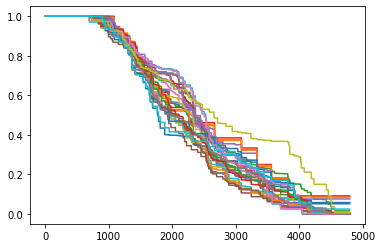

In [5]:
for i in range(30):
  plt.plot(preds.mean(axis=1)[i])

In [6]:
X_train, T_train, E_train, X_test, T_test, E_test = data.pysurvival_split()

In [7]:
avg_preds = preds.mean(axis=1)

In [8]:
avg_preds.shape

torch.Size([84, 4795])

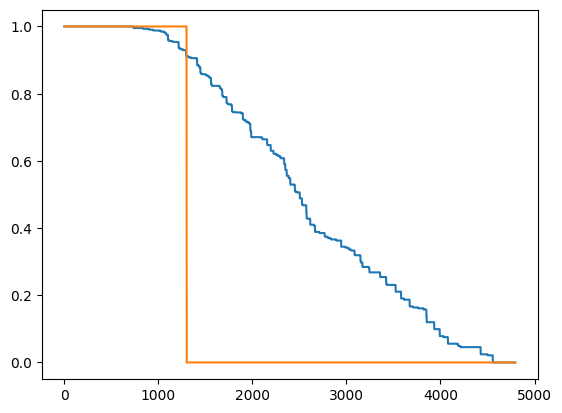

In [9]:
plt.plot(avg_preds[0])
plt.plot(y_test[0])

In [10]:
avg_preds.shape, y_test.shape

(torch.Size([84, 4795]), torch.Size([84, 4795]))

In [11]:
avg_preds

tensor([[1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 1.0000, 1.0000,  ..., 0.0034, 0.0034, 0.0034],
        [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 0.0011, 0.0011, 0.0011],
        [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000]])

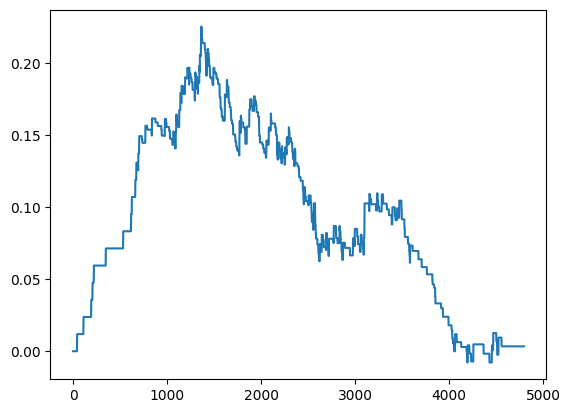

In [12]:
plt.plot(((avg_preds-np.nan_to_num(y_test, 0)**2).mean(axis=0)))

In [13]:
y_test.shape, avg_preds.shape

(torch.Size([84, 4795]), torch.Size([84, 4795]))

In [14]:
class Brier:
  def __init__(self, times, event_observed):
    from lifelines import KaplanMeierFitter
    self.times = times
    self.event_observed = event_observed
    self.num_events = sum(event_observed)
    self.kmf = KaplanMeierFitter()
    self.kmf.fit(self.times, self.event_observed)
    cumulative_censoring_probs = 1 - self.kmf.survival_function_.values
    self.ipcw_coeffs = (1 / cumulative_censoring_probs)[1:]

  def evaluate(self, times_arr, predicted_probs):
    if isinstance(times_arr, torch.Tensor): times_arr = times_arr.numpy()
    if isinstance(predicted_probs, torch.Tensor): predicted_probs = predicted_probs.numpy()
    print(np.power(times_arr - predicted_probs, 2).mean(axis=0).shape)
    brier_score = (self.ipcw_coeffs*np.power(times_arr - predicted_probs, 2)).mean(axis=0) / self.num_events
    return brier_score

(4795,)


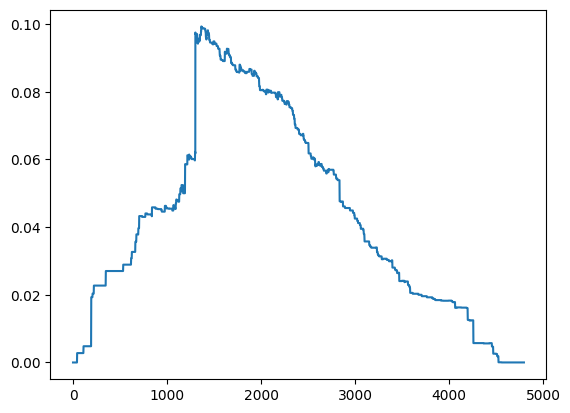

In [15]:
_bs_ = Brier(T_test, E_test)
bs_vspyct = _bs_.evaluate(y_test, avg_preds)
plt.plot(bs_vspyct)

In [3]:
# def brier_score_ipcw(times, times_arr, event_observed, predicted_probs):
#     from lifelines import KaplanMeierFitter
#     if isinstance(times_arr, torch.Tensor): times_arr = times_arr.numpy()
#     if isinstance(predicted_probs, torch.Tensor): predicted_probs = predicted_probs.numpy()
#     num_events = sum(event_observed)
#     kmf = KaplanMeierFitter()
#     kmf.fit(times, event_observed)
#     cumulative_censoring_probs = 1 - kmf.survival_function_.values
#     ipcw_coeffs = 1 / cumulative_censoring_probs
#     ipcw_coeffs = ipcw_coeffs[1:]

#     brier_sum = []
#     for (t, _, pred_prob, ipcw_coeff) in zip(times_arr, event_observed, predicted_probs, ipcw_coeffs): brier_sum.append(ipcw_coeff*(t - pred_prob) ** 2)
#     brier_sum = np.array(brier_sum).mean(axis=0)
#     return brier_sum / num_events

In [16]:
from pysurvival.models.multi_task import LinearMultiTaskModel
mtlr = LinearMultiTaskModel()
mtlr.fit(X_train, T_train, E_train, lr=0.0001, l2_reg=1e-2, init_method='zeros')

predicted_mtlr = mtlr.predict_survival(X_test)
transformed_predictions_mtlr = fix_predictions(predicted_mtlr, mtlr.times, T_train.max())

% Completion: 100%|***********************************************|Loss:  38.03


(4795,)


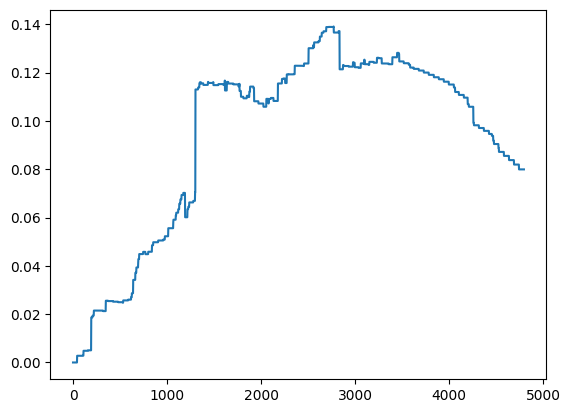

In [17]:
bs_mtlr = _bs_.evaluate(y_test, transformed_predictions_mtlr)
plt.plot(bs_mtlr)

In [18]:
from pysurvival.models.survival_forest import RandomSurvivalForestModel

rsf = RandomSurvivalForestModel(num_trees=50)
rsf.fit(X_train, T_train, E_train, max_features="sqrt", max_depth=5)

RandomSurvivalForestModel

In [19]:
predicted_rsf = rsf.predict_survival(X_test)
transformed_predictions_rsf = fix_predictions(predicted_rsf, rsf.times, int(T_train.max()))

(4795,)


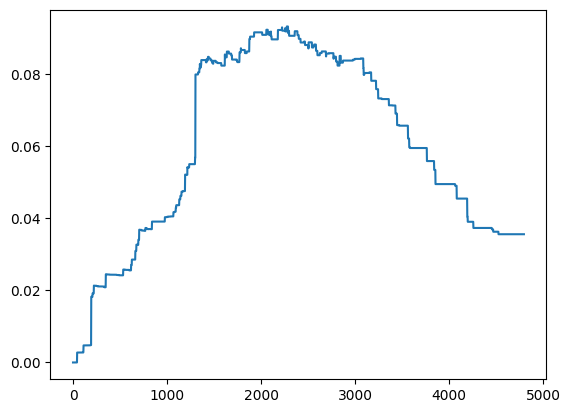

In [20]:
bs_rsf = _bs_.evaluate(y_test, transformed_predictions_rsf)
plt.plot(bs_rsf)

In [19]:
from pysurvival.models.semi_parametric import CoxPHModel

coxph = CoxPHModel()
coxph.fit(X_train, T_train, E_train, lr=0.01, l2_reg=1e-2, init_method='zeros')

Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 714.551 - ||grad||^2 = 404.22307
 * Iteration #2 - Loss = 698.182 - ||grad||^2 = 399.76632
 * Iteration #3 - Loss = 688.456 - ||grad||^2 = 395.63918
 * Iteration #4 - Loss = 679.989 - ||grad||^2 = 391.58569
 * Iteration #5 - Loss = 672.359 - ||grad||^2 = 387.59254
 * Iteration #6 - Loss = 665.347 - ||grad||^2 = 383.65324
 * Iteration #7 - Loss = 658.821 - ||grad||^2 = 379.76382
 * Iteration #8 - Loss = 652.692 - ||grad||^2 = 375.92157
 * Iteration #9 - Loss = 646.897 - ||grad||^2 = 372.12447
 * Iteration #10 - Loss = 641.387 - ||grad||^2 = 368.37093
 * Iteration #11 - Loss = 636.125 - ||grad||^2 = 364.65965
 * Iteration #12 - Loss = 631.082 - ||grad||^2 = 360.98954
 * Iteration #13 - Loss = 626.233 - ||grad||^2 = 357.35965
 * Iteration #14 - Loss = 621.560 - ||grad||^2 = 353.76914
 * Iteration #15 - Loss = 617.044 - ||grad||^2 = 350.21724
 * Iteration #16 - Loss = 612.672 - ||grad||^2 = 346.70326
 * Iteration #17 - Loss = 

CoxPHModel

In [20]:
predicted_coxph = coxph.predict_survival(X_test)
transformed_predictions_coxph = fix_predictions(predicted_coxph, coxph.times, int(T_train.max()))

In [21]:
bs_ipcw_coxph = brier_score_ipcw(T_test, y_test, E_test, transformed_predictions_coxph)

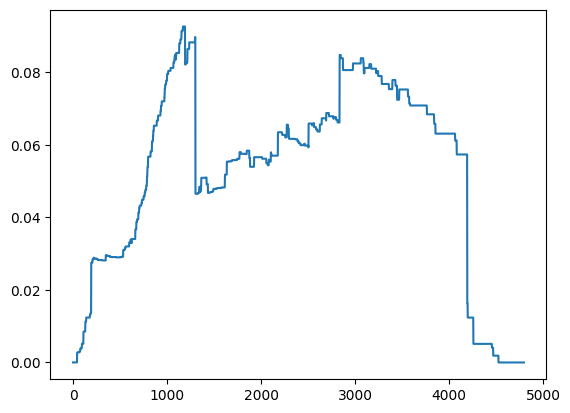

In [22]:
plt.plot(bs_ipcw_coxph)

In [21]:
import spyct

model = spyct.Model()
model.fit(X_train.values, y_train.numpy())

In [22]:
preds_spyct = model.predict(y_test.numpy())

In [23]:
preds_spyct.shape

(84, 4795)

(4795,)


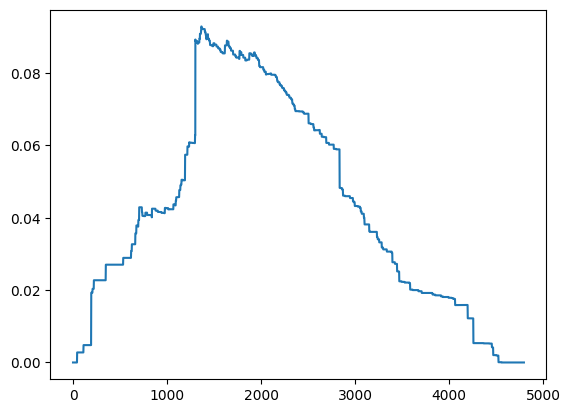

In [24]:
bs_spyct = _bs_.evaluate(y_test, preds_spyct)
plt.plot(bs_spyct)

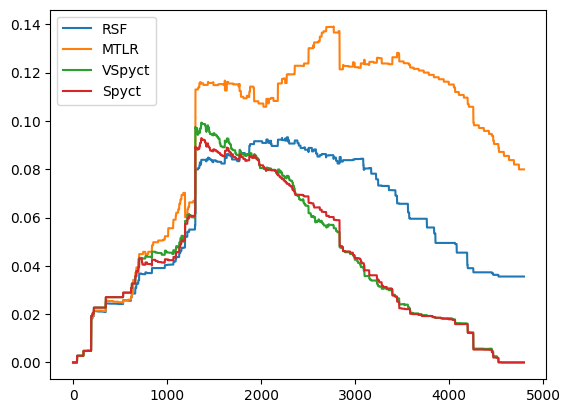

In [25]:
plt.plot(bs_rsf, label='RSF')
plt.plot(bs_mtlr, label='MTLR')
# plt.plot(bs_ipcw_coxph, label='CoxPH')
plt.plot(bs_vspyct, label='VSpyct')
plt.plot(bs_spyct, label='Spyct')
plt.legend()
plt.savefig('../reports/figures/first_brier_scores.pdf', bbox_inches='tight')

Next steps:

1) Adjust the VSpyct model to account for missing target variables. It should work in a SSL manner, same as the original SPYCT - FIXED 
2) Add PyCox models to the game - TODO 
3) Do the evaluations with 5-fold CV - TODO 

In [351]:
def gen_surv_nan(num_samples, num_days=365, missing_prob=0.1, nan_start_day=200):
    num_features = 5  # Replace with the actual number of features

    X = np.random.rand(num_samples, num_features)

    y = np.zeros((num_samples, num_days))
    for i in range(num_samples):
        survival_prob = np.linspace(1, 0, num_days) * np.random.uniform(0.5, 1.5)

        # Introduce missing values after the specified time point
        nan_start_day = min(nan_start_day, num_days)  # Ensure nan_start_day is within the valid range
        missing_indices = np.arange(nan_start_day, num_days)
        y[i, missing_indices] = np.nan

        y[i, :nan_start_day] = survival_prob[:nan_start_day]

    return X, y

def generate_survival_function_data(num_samples, num_days=365):
  X = np.random.rand(num_samples, num_features)  

  y = np.zeros((num_samples, num_days))
  for i in range(num_samples):
    y[i] = np.linspace(1, 0, num_days) * np.random.uniform(0.5, 1.5)

  return X, y

In [160]:
print(fake_weights.shape, y.shape)
print(torch.matmul(fake_weights, y[:,0]))

torch.Size([1000]) torch.Size([1000, 365])
tensor(-6.4459)


In [224]:
def weighted_variance(values, weights, weight_sum):
    mean = torch.matmul(weights, values) / weight_sum
    return -torch.sum(mean*mean)

In [225]:
def wvar(values, weights, weight_sum):
    _list = []
    for i in range(values.shape[1]):
        valid_indices = ~torch.isnan(values[:, i])
        _list.append(torch.matmul(weights[valid_indices], values[valid_indices, i]))
    _list = [z**2 for z in [x/weight_sum.item() for x in _list]]
    return -(sum(_list))

In [347]:
def _wvar(values, weights, weight_sum):
    valid_indices = ~torch.isnan(values)
    weighted_values = values * weights.view(-1, 1)
    weighted_values[~valid_indices] = 0  # Set invalid values to 0
    variance = ((weighted_values.sum(dim=0) / weight_sum) ** 2).sum()
    return -variance

In [353]:
_wvar(y, fake_weights, torch.sum(fake_weights))

tensor(-168.5716)

In [354]:
weighted_variance(y, fake_weights, torch.sum(fake_weights))

tensor(nan)

In [355]:
wvar(y, fake_weights, torch.sum(fake_weights))

tensor(-168.5716)

In [343]:
# Example usage:
num_samples = 1000
num_days = 365
num_features = 10

X, y = generate_survival_function_data(num_samples, num_days=num_days)
X, y = torch.Tensor(X), torch.Tensor(y)

In [352]:
# Example usage:
num_samples = 1000
num_days = 365
num_features = 10

X, y = gen_surv_nan(num_samples, num_days=num_days)
X, y = torch.Tensor(X), torch.Tensor(y)

In [282]:
fake_weights = torch.randn(1000)

In [99]:
y.shape, fake_weights.shape

(torch.Size([1000, 365]), torch.Size([1000]))

In [228]:
print(weighted_variance(y, fake_weights, torch.sum(fake_weights)), wvar(y, fake_weights, torch.sum(fake_weights)))

tensor(-97.7671) tensor(-97.7671)


In [236]:
weighted_variance(y, fake_weights, torch.sum(fake_weights)) - wvar(y, fake_weights, torch.sum(fake_weights))

tensor(1.5259e-05)

In [117]:
wvar(y, fake_weights, torch.sum(fake_weights)).shape

torch.Size([1000])

In [268]:
def impurity(values): return torch.sum(torch.var(values, dim=0))

In [271]:
impurity(y)

tensor(9.8679)

In [274]:
torch.var(y, dim=0).shape

torch.Size([365])

In [304]:
def nanvar(y, dim=0):
    mask = ~torch.isnan(y)
    masked_y = y.masked_fill(~mask, 0)
    masked_mean = masked_y.sum(dim=dim) / mask.sum(dim=dim)
    squared_diff = (masked_y - masked_mean.view(1, -1))**2
    var = torch.sum(squared_diff, dim=dim) / (mask.sum(dim=dim) - 1)
    return var

In [341]:
def _nanvar(y, dim=0):
    mean = torch.nanmean(y, dim)
    squared_diff = (y - mean.unsqueeze(dim)) ** 2
    valid_count = torch.sum(~torch.isnan(y), dim)
    variance = torch.nansum(squared_diff, dim) / (valid_count - 1)
    
    return variance

In [344]:
torch.sum(_nanvar(y)), torch.sum(torch.var(y, dim=0))

(tensor(10.3796), tensor(10.3796))

In [331]:
torch.var(y.numpy(), axis=0)

AttributeError: module 'torch' has no attribute 'nanvar'

In [346]:
_nanvar(y).shape

torch.Size([365])

In [ ]:
# vidi gi posteriorite za root node i sporedi gi so priorite. Kolku se imaat pomesteno?
# proveri deka predictive semplira od posteriorite a ne od nesto drugo
# sporedba posterior na root node na vspyct so root nodovite na site drva od ensemble od originalen spyct

In [15]:
model.root_node.split_model

PyroLinear(in_features=769, out_features=1, bias=True)

In [6]:
import pyro
pyro.get_param_store()

In [7]:
from pyro.infer import Predictive
root_pred = Predictive(model=model.root_node.split_model, guide=model.root_node.guide, num_samples=1000)
preds = root_pred(X_test)

ValueError: tensor([[-1.5206,  1.5784, -0.4818,  ...,  0.0000,  0.0000,  1.0000],
        [ 0.1206, -0.3970, -0.5272,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.1206,  1.5784, -0.5726,  ...,  0.0000,  0.0000,  1.0000],
        ...,
        [ 0.1382, -0.3970, -0.1183,  ...,  0.0000,  0.0000,  1.0000],
        [-0.0090, -0.3970, -0.4363,  ...,  0.0000,  1.0000,  0.0000],
        [ 0.7120, -0.3970,  0.4496,  ...,  0.0000,  0.0000,  1.0000]]) is not callable, did you mean to pass it as a keyword arg?
Trace Shapes:
 Param Sites:
Sample Sites:

In [57]:
root_pred_prior = Predictive(model.root_node.split_model, {}, num_samples=1000)
preds_prior = root_pred(X_test)

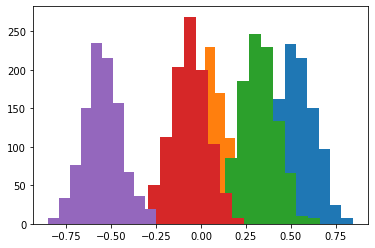

In [58]:
lin = preds['linear.weight']
for i in range(5):
  plt.hist(lin.reshape(lin.shape[0], lin.shape[-1])[:,i].numpy().tolist())

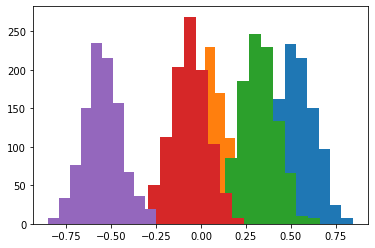

In [59]:
lin_prior = preds['linear.weight']
for i in range(5):
  plt.hist(lin.reshape(lin_prior.shape[0], lin_prior.shape[-1])[:,i].numpy().tolist())

In [4]:
import pyro

In [5]:
param_store_prior = model.root_node.param_store

In [6]:
param_store_prior.shape

torch.Size([770])

In [7]:
param_store_posterior = pyro.get_param_store()['AutoDiagonalNormal.loc']

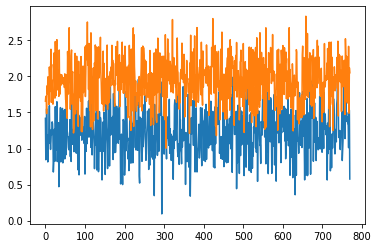

In [8]:
plt.plot(param_store_prior.detach())
plt.plot(param_store_posterior.detach())